
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split as sksplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [4]:
def train_test_split(df):
    return sksplit(df, test_size=0.2, random_state=42)
#Split the data into a training set, and test set 
def accuracy(pred, actual):
    return np.sum(np.equal(pred, actual))/len(pred)
# Calculate the accuracy percentage of the predicted values

In [5]:
X = pd.read_pickle('transformed_data.pkl')
y = pd.read_pickle('transformed_y.pkl')
X_train, X_val = train_test_split(X)
Y_train = y[X_train.index]
Y_val = y[X_val.index]

<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods.


## Logistic Regression

In [146]:
from sklearn.linear_model import LogisticRegression

In [147]:
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1.0).fit(X_train, Y_train)
training_accuracy = accuracy(log_model.predict(X_train), Y_train)
val_accuracy = accuracy(log_model.predict(X_val), Y_val)
print(training_accuracy, val_accuracy)

0.4103214890016921 0.4222972972972973


In [148]:
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1)
selector = RFECV(log_model, step=1, cv=5).fit(X, y)
rank=selector.ranking_

In [170]:
pens=np.linspace(0.1,5.1,50)
fets=range(1, max(rank)+1)
val_acc=[[0 for i in range(0, len(pens))] for j in range(0, len(fets))]

for i in range(0,len(fets)):
    n=fets[i]
    X_r=X[X.columns[rank<=n]]
    for j in range(0,len(pens)):
        log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=pens[j])
        val_acc[i][j] = np.mean(cross_val_score(log_model, X_r, y, cv=5))

In [171]:
val_mat=np.matrix(val_acc)
a,b=np.unravel_index(val_mat.argmax(), val_mat.shape)
val_mat[a,b]

0.3727529127068806

In [172]:
n_opt=fets[a]
log_pen=pens[b]

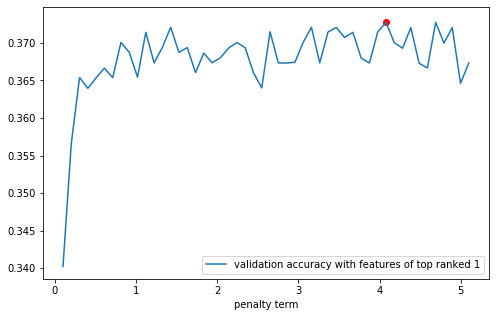

In [173]:
plt.figure(figsize=(8,5))
for i in range(0,len(fets)):
    n=fets[i]
    plt.plot(pens, val_acc[i], label='validation accuracy with features of top ranked '+str(n))
plt.scatter(pens[b], val_mat[a,b], color='r')
plt.xlabel('penalty term')
plt.legend();

In [174]:
columns=X.columns[rank<=n_opt]
X_train_log=X_train[columns]
X_val_log=X_val[columns]

log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen).fit(X_train_log, Y_train)

training_accuracy = accuracy(log_model.predict(X_train_log), Y_train)
val_accuracy = accuracy(log_model.predict(X_val_log), Y_val)
print(training_accuracy, val_accuracy)

0.41624365482233505 0.40202702702702703


Based on the result of EDA, next we will train logistic classifier on two types of samples, one has image size lower than 300000, and the other has image size larger or equal to 300000, and see if it can provide us a better result.

In [168]:
X_train_small=X_train_log[X_train_log['size']<300000]
Y_train_small=Y_train[X_train_log['size']<300000]
X_val_small=X_val_log[X_val_log['size']<300000]
Y_val_small=Y_val[X_val_log['size']<300000]

X_train_large=X_train_log[X_train_log['size']>=300000]
Y_train_large=Y_train[X_train_log['size']>=300000]
X_val_large=X_val_log[X_val_log['size']>=300000]
Y_val_large=Y_val[X_val_log['size']>=300000]

In [177]:
log_model_small = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)
log_model_large = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)
errors = []

training_accuracy_small = accuracy(log_model_small.fit(X_train_small, Y_train_small).predict(X_train_small), Y_train_small)
val_accuracy_small = accuracy(log_model_small.predict(X_val_small), Y_val_small)
print(training_accuracy_small, val_accuracy_small)

training_accuracy_large = accuracy(log_model_large.fit(X_train_large, Y_train_large).predict(X_train_large), Y_train_large)
val_accuracy_large = accuracy(log_model_large.predict(X_val_large), Y_val_large)
print(training_accuracy_large, val_accuracy_large)

print("average validation error:")
print((val_accuracy_small*len(X_train_small)+val_accuracy_large*len(X_train_large))/len(X_train_log))

0.5046875 0.5
0.34870848708487084 0.359375
average validation error:
0.43551713197969544


### The average validation error for our final logistic regression classifier is 0.43551713197969544, with all features selected and 4.079591836734694 regularization term.

## K-nearest Neighbors

In [6]:
from sklearn.neighbors import KNeighborsClassifier

Let's first try to fit KNN classifier on the whole dataset

In [33]:
neighbors =range (1, 251, 10)
vals=[]
for n_neighbors in neighbors:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
    training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
    val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
    vals.append(val_accuracy)

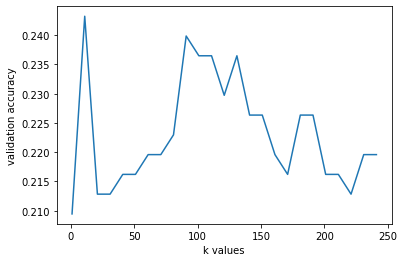

In [34]:
plt.plot(neighbors, vals)
plt.xlabel('k values')
plt.ylabel('validation accuracy');

KNN seems to perform better when the k values is between 1-20, so let's get a closer look here.

In [36]:
neighbors =range (1, 20)
vals=[]
for n_neighbors in neighbors:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
    training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
    val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
    vals.append(val_accuracy)

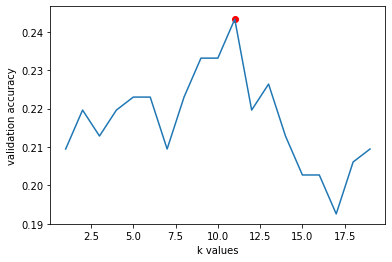

In [37]:
plt.plot(neighbors, vals)
plt.scatter(neighbors[np.argmax(vals)], max(vals), color='r')
plt.xlabel('k values')
plt.ylabel('validation accuracy');

In [38]:
n_neighbors=neighbors[np.argmax(vals)]
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
print(training_accuracy, val_accuracy)

0.3147208121827411 0.24324324324324326


The validation accuracy of the current KNN is 0.24324324324324326, so let's further try to fit KNN on images with small image size and those with large image size separately.

In [63]:
X_tr_sknn=X_train[X_train['size']<300000]
Y_tr_sknn=Y_train[X_train['size']<300000]
X_val_sknn=X_val[X_val['size']<300000]
Y_val_sknn=Y_val[X_val['size']<300000]

X_tr_lknn=X_train[X_train['size']>=300000]
Y_tr_lknn=Y_train[X_train['size']>=300000]
X_val_lknn=X_val[X_val['size']>=300000]
Y_val_lknn=Y_val[X_val['size']>=300000]

In [80]:
neighbors =range (1, 100)
train_small=[]
vals_small=[]
for n_neighbors in neighbors:
    knn_model_small = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_tr_sknn, Y_tr_sknn)
    train_accuracy_small = accuracy(knn_model_small.predict(X_tr_sknn), Y_tr_sknn)
    val_accuracy_small = accuracy(knn_model_small.predict(X_val_sknn), Y_val_sknn)
    train_small.append(train_accuracy_small)
    vals_small.append(val_accuracy_small)

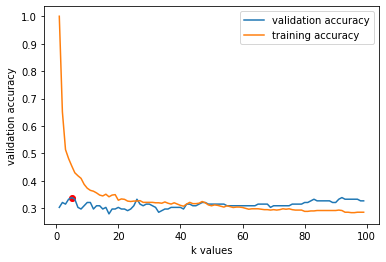

In [82]:
plt.plot(neighbors, vals_small, label='validation accuracy')
plt.plot(neighbors, train_small, label='training accuracy')
plt.scatter(neighbors[np.argmax(vals_small)], max(vals_small), color='r')
plt.xlabel('k values')
plt.legend()
plt.ylabel('validation accuracy');

In [83]:
neighbors =range (1, 100)
train_large=[]
vals_large=[]
for n_neighbors in neighbors:
    knn_model_large = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_tr_lknn, Y_tr_lknn)
    train_accuracy_large = accuracy(knn_model_large.predict(X_tr_lknn), Y_tr_lknn)
    val_accuracy_large = accuracy(knn_model_large.predict(X_val_lknn), Y_val_lknn)
    train_large.append(train_accuracy_large)
    vals_large.append(val_accuracy_large)

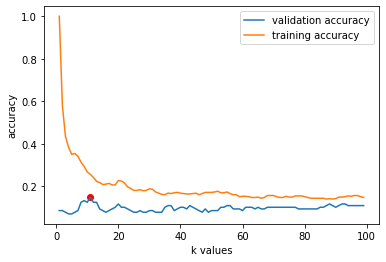

In [84]:
plt.plot(neighbors, vals_large, label='validation accuracy')
plt.plot(neighbors, train_large, label='training accuracy')
plt.scatter(neighbors[np.argmax(vals_large)], max(vals_large), color='r')
plt.xlabel('k values')
plt.legend()
plt.ylabel('accuracy');

In [85]:
print("average validation error:")
print((max(vals_small)*len(X_tr_sknn)+max(vals_large)*len(X_tr_lknn))/len(X_train))

average validation error:
0.2517732505438724


In [86]:
neighbors[np.argmax(vals_large)]

11

In [88]:
max(vals_small)

0.3392857142857143

In [89]:
max(vals_large)

0.1484375

### The average validation error for our final KNN classifier is 0.2517732505438724, where the chosen k value is 11, validation error on small images is 0.3392857142857143, and that on big images is 0.1484375.

## Classification Tree

In [143]:
from sklearn.tree import DecisionTreeClassifier

In [144]:
val_acc=[]
train_acc=[]
deps=range(1, 100)
for j in deps:
    dtree_model = DecisionTreeClassifier(max_depth=j).fit(X_train, Y_train)
    train_acc.append(accuracy(dtree_model.predict(X_train), Y_train))
    val_acc.append(accuracy(dtree_model.predict(X_val), Y_val))

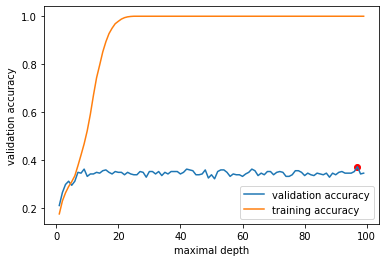

In [145]:
plt.plot(deps, val_acc, label='validation accuracy')
plt.plot(deps, train_acc, label='training accuracy')
plt.scatter(deps[np.argmax(val_acc)], max(val_acc), color='r')
plt.xlabel('maximal depth')
plt.ylabel('validation accuracy')
plt.legend();

In [58]:
dtree_model = DecisionTreeClassifier(max_depth=deps[np.argmax(val_acc)]).fit(X_train, Y_train)
val_accuracy=accuracy(dtree_model.predict(X_val), Y_val)
print(val_accuracy)

0.35135135135135137


In [90]:
deps[np.argmax(val_acc)]

28

### With chosen max depth value 28, the validation accuracy of the classification tree is 0.35135135135135137.

## Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
forest_model = RandomForestClassifier(n_estimators=100, 
                                    bootstrap = True, 
                                    max_features = 'sqrt', 
                                    max_depth=None)
selector = RFECV(forest_model, step=1, cv=5).fit(X, y)
rank=selector.ranking_

In [94]:
val_acc=[]
deps=range(1,25)
fets=range(1, max(rank)+1)
val_acc=[[0 for i in range(0, len(deps))] for j in range(0, len(fets))]

for i in range(0,len(fets)):
    n=fets[i]
    X_r=X[X.columns[rank<=n]]
    for j in range(0,len(deps)):
        forest_model = RandomForestClassifier(n_estimators=100, 
                                                      bootstrap = True, 
                                                      max_features = 'sqrt', 
                                                      max_depth=deps[j])

        val_acc[i][j] = np.mean(cross_val_score(forest_model, X_r, y, cv=5))

In [95]:
val_mat = np.matrix(val_acc)
a,b=np.unravel_index(val_mat.argmax(), val_mat.shape)
val_mat[a,b]

0.36643192045768586

In [96]:
n_opt=fets[a]
rf_dep=deps[b]

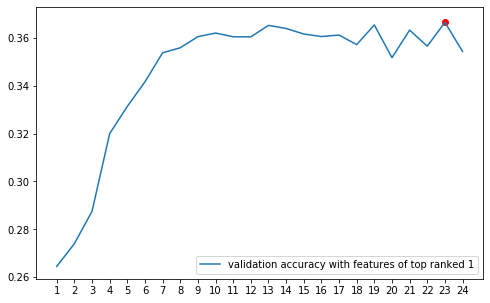

In [97]:
plt.figure(figsize=(8,5))
#plt.plot(deps, train_acc, label='train accuracy')
for i in range(0,len(fets)):
    n=fets[i]
    plt.plot(deps, val_acc[i], label='validation accuracy with features of top ranked '+str(n))
plt.scatter(rf_dep, val_mat[a,b], color='r')
plt.xticks(deps)
plt.legend();

In [101]:
rf_dep

23

In [100]:
columns=X.columns[rank<=n_opt]
X_train_rf=X_train[columns]
X_val_rf=X_val[columns]

forest_model = RandomForestClassifier(n_estimators=100, 
                                      bootstrap = True, 
                                      max_features = 'sqrt', 
                                      max_depth=rf_dep).fit(X_train_rf, Y_train)
training_accuracy = accuracy(forest_model.predict(X_train_rf), Y_train)
val_accuracy = accuracy(forest_model.predict(X_val_rf), Y_val)
print(training_accuracy, val_accuracy)

1.0 0.40878378378378377


### With all features selected and maximal depth 23, the validation accuracy of our final random forest is 0.40878378378378377.

## Support Vector Machine

In [104]:
from sklearn.svm import SVC

In [113]:
svc_model = SVC(C=1.0, tol=2).fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
print(training_accuracy)

1.0


In [139]:
tols= range(1, 10)
val_svm=[]
train_svm=[]
for t in tols:
    svc_model = SVC(C=1.0, tol=t).fit(X_train, Y_train)
    training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
    val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
    val_svm.append(val_accuracy)
    train_svm.append(training_accuracy)

In [140]:
t = tols[val_svm.index(max(val_svm))]
t

2

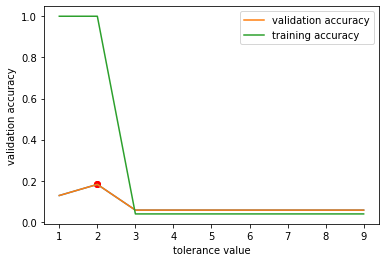

In [141]:
plt.plot(tols, val_svm)
plt.scatter(t, max(val_svm), color='r')
plt.xlabel('tolerance value')
plt.ylabel('validation accuracy');

plt.plot(tols, val_svm, label='validation accuracy')
plt.plot(tols, train_svm, label='training accuracy')
plt.scatter(t, max(val_svm), color='r')
plt.xlabel('tolerance value')
plt.ylabel('validation accuracy')
plt.legend();

In [126]:
svc_model = SVC(C=1.0, tol=t).fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
print(val_accuracy)

0.18243243243243243


Let's also try to tune regularization parameter, C.

In [137]:
cs = np.linspace(0.1,5.1,20)
val_svm=[]
train_svm=[]
for c in cs:
    svc_model = SVC(C=c, tol=t).fit(X_train, Y_train)
    training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
    val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
    val_svm.append(val_accuracy)
    train_svm.append(training_accuracy)

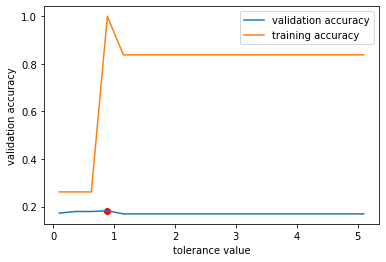

In [138]:
plt.plot(cs, val_svm, label='validation accuracy')
plt.plot(cs, train_svm, label='training accuracy')
plt.scatter(cs[np.argmax(val_svm)], max(val_svm), color='r')
plt.xlabel('tolerance value')
plt.ylabel('validation accuracy')
plt.legend();

But the result validation accuracy is still very low and doesn't improve much, so we still keep C as 1.

In [136]:
svc_model = SVC(C=1.0, tol=t).fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
print(val_accuracy)

0.18243243243243243


### The validation accuracy of our SVM classifier, with C=1 and tol=2,  is 0.18243243243243243.

## Test on test data

In [16]:
test_data=pd.read_pickle("transformed_data_test.pkl")
X_test=test_data

In [17]:
X_test

,size,red_avg,aspectratio,green_avg,blue_avg,red_std,green_std,blue_std,grey_std,colorful,num_blob,red_rank,green_rank,blue_rank
Id,,,,,,,,,,,,,,
0,1620000,105.980433,0.666667,106.905494,105.590887,67.205121,65.316848,63.113690,0.256376,171.341564,88,1.000000,1.000000,1.000000
1,91821,144.792694,0.526971,147.593426,133.982324,79.839361,77.287288,76.796918,0.304696,159.033671,16,1.000000,1.000000,1.000000
2,312006,133.637670,1.171141,123.831301,118.584796,68.821922,72.801423,82.262728,0.284262,175.422400,10,1.000000,1.000000,1.000000
3,70308,96.696962,0.656085,83.622675,85.577701,61.854443,52.434449,48.460702,0.212077,147.802648,2,1.000000,1.000000,1.000000
4,244650,23.246266,1.502146,40.598455,46.887554,25.818695,28.859210,34.166635,0.111580,93.570925,1,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1229580,82.298175,0.624691,88.592117,138.559137,33.266301,34.144022,46.221502,0.135341,73.953556,25,1.000000,1.000000,1.000000
712,490032,101.633914,0.658635,128.388609,163.542010,67.142158,70.383417,65.551384,0.266364,88.947355,10,0.929878,0.929878,0.929878
713,185115,96.093250,0.749129,126.238344,162.929860,53.152277,59.381154,72.718032,0.229114,82.100547,6,1.000000,1.000000,1.000000


In [18]:
columns=X_test.columns[rank<=n_opt]
X_test_log=X_test[columns]

X_test_small=X_test_log[X_test_log['size']<300000]
#Y_test_small=Y_test[X_test_log['size']<300000]

X_test_large=X_test_log[X_test_log['size']>=300000]
#Y_test_large=Y_test[X_test_log['size']>=300000]

In [20]:
y_hat_small=log_model_small.predict(X_test_small)
y_hat_small=pd.DataFrame({
    'index':X_test_small.index,
    'encoding':y_hat_small
})

y_hat_large=log_model_large.predict(X_test_large)
y_hat_large=pd.DataFrame({
    'index':X_test_large.index,
    'encoding':y_hat_large
})

In [21]:
y_hat=pd.concat([y_hat_small, y_hat_large])
y_hat=y_hat.sort_values(by='index').set_index(keys='index')
y_hat

,encoding
index,
0,19
1,12
2,5
3,12
4,3
...,...
711,11
712,11
713,6


In [27]:
y_hat.to_csv('predictions.csv', index=False, header=False)